In [1]:
import numpy as np
import sys
import os
import torch
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dframe = pd.DataFrame

#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/heka/code/retrieval_app


In [2]:
from core.resnet_wider import resnet50x4

with torch.no_grad():
    repnet = resnet50x4()
repnet.eval()
print()

repnet_pth = './model_data/resnet50-4x.pth'
state_dict = torch.load(repnet_pth)['state_dict']
repnet.load_state_dict(state_dict)

<All keys matched successfully>

## Static size:

In [12]:
x = torch.randn(1, 3, 224, 224, device='cpu')
logit_t, rep_t = repnet(x)

torch.onnx.export(repnet, x, "repnet_static.onnx", verbose=False, input_names=['img_tensor'], output_names=['logit', 'rep'])

In [16]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("repnet_static.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
logit_o, rep_o = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(rep_t), rep_o, rtol=1e-03, atol=1e-05)

#print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [20]:
%timeit repnet(x)

932 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit ort_session.run(None, ort_inputs)

467 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Dynamic shape:

In [23]:
x = torch.randn(1, 3, 224, 224, device='cpu')
logit_t, rep_t = repnet(x)

torch.onnx.export(repnet, 
                  x, 
                  "repnet_dynamic.onnx", 
                  verbose=False, 
                  input_names=['img_tensor'], 
                  output_names=['logit', 'rep'],
                  dynamic_axes={'img_tensor' : {2:'height', 3:'width'},    # variable lenght axes
                                'rep' : {2:'height', 3:'width'}})

In [29]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("repnet_dynamic.onnx")

x = torch.randn(1, 3, 256, 256, device='cpu')
logit_t, rep_t = repnet(x)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
logit_o, rep_o = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(rep_t), rep_o, rtol=1e-03, atol=1e-04)  # NOTE atol!

#print("Exported model has been tested with ONNXRuntime, and the result looks good!")

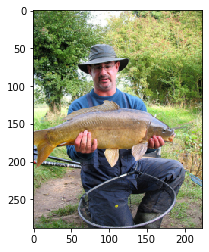

In [61]:
from PIL import Image
from core.augs import load_augs
import torchvision.transforms as transforms

augs = load_augs(resize_to=224)

# Test image:
path_img = '/media/heka/TERA/Data/imagenet2/train/n01440764/n01440764_18.JPEG'
img = Image.open(path_img).convert('RGB')
img = augs['augs_base'](img)
img = np.array(img)


plt.imshow(img)
plt.show()

x = transforms.ToTensor()(img)[None]

logit_t, rep_t = repnet(x)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
logit_o, rep_o = ort_session.run(None, ort_inputs)

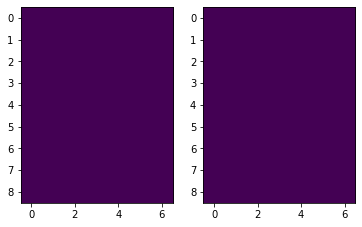

In [69]:
i = np.random.randint(0, 8000)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(to_numpy(rep_t)[0, i])
ax[1].imshow(rep_o[0, i])
plt.show()


In [70]:
%timeit ort_session.run(None, ort_inputs)

580 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Conclusions:
- even with dynamic shapes, ONNX is about 1.6 times faster on CPU

In [71]:
x = dict(a=1, b=2)
y = dict(c=3)
x.update(y)
print(x)

{'a': 1, 'b': 2, 'c': 3}


In [75]:
df = pd.read_csv('https://storage.googleapis.com/openimages/v5/train-annotations-human-imagelabels-boxable.csv')
df.head()

,ImageID,Source,LabelName,Confidence
0,000002b66c9c498e,verification,/m/014j1m,0
1,000002b66c9c498e,verification,/m/014sv8,1
2,000002b66c9c498e,verification,/m/01599,0
3,000002b66c9c498e,verification,/m/015p6,0
4,000002b66c9c498e,verification,/m/015x4r,0


In [83]:
class_names = pd.read_csv('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv', header=None)
class_names.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [84]:
class_names = pd.read_csv('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv', header=None).to_dict()
idx2name = class_names[0]
name2idx = {val:key for key, val in idx2name.items()}
idx2description = class_names[1]

In [87]:
idx2description

{0: 'Tortoise',
 1: 'Container',
 2: 'Magpie',
 3: 'Sea turtle',
 4: 'Football',
 5: 'Ambulance',
 6: 'Ladder',
 7: 'Toothbrush',
 8: 'Syringe',
 9: 'Sink',
 10: 'Toy',
 11: 'Organ (Musical Instrument)',
 12: 'Cassette deck',
 13: 'Apple',
 14: 'Human eye',
 15: 'Cosmetics',
 16: 'Paddle',
 17: 'Snowman',
 18: 'Beer',
 19: 'Chopsticks',
 20: 'Human beard',
 21: 'Bird',
 22: 'Parking meter',
 23: 'Traffic light',
 24: 'Croissant',
 25: 'Cucumber',
 26: 'Radish',
 27: 'Towel',
 28: 'Doll',
 29: 'Skull',
 30: 'Washing machine',
 31: 'Glove',
 32: 'Tick',
 33: 'Belt',
 34: 'Sunglasses',
 35: 'Banjo',
 36: 'Cart',
 37: 'Ball',
 38: 'Backpack',
 39: 'Bicycle',
 40: 'Home appliance',
 41: 'Centipede',
 42: 'Boat',
 43: 'Surfboard',
 44: 'Boot',
 45: 'Headphones',
 46: 'Hot dog',
 47: 'Shorts',
 48: 'Fast food',
 49: 'Bus',
 50: 'Boy',
 51: 'Screwdriver',
 52: 'Bicycle wheel',
 53: 'Barge',
 54: 'Laptop',
 55: 'Miniskirt',
 56: 'Drill (Tool)',
 57: 'Dress',
 58: 'Bear',
 59: 'Waffle',
 60: 'Pa

In [86]:
name2idx

{'/m/011k07': 0,
 '/m/011q46kg': 1,
 '/m/012074': 2,
 '/m/0120dh': 3,
 '/m/01226z': 4,
 '/m/012n7d': 5,
 '/m/012w5l': 6,
 '/m/012xff': 7,
 '/m/012ysf': 8,
 '/m/0130jx': 9,
 '/m/0138tl': 10,
 '/m/013y1f': 11,
 '/m/01432t': 12,
 '/m/014j1m': 13,
 '/m/014sv8': 14,
 '/m/014trl': 15,
 '/m/014y4n': 16,
 '/m/0152hh': 17,
 '/m/01599': 18,
 '/m/01_5g': 19,
 '/m/015h_t': 20,
 '/m/015p6': 21,
 '/m/015qbp': 22,
 '/m/015qff': 23,
 '/m/015wgc': 24,
 '/m/015x4r': 25,
 '/m/015x5n': 26,
 '/m/0162_1': 27,
 '/m/0167gd': 28,
 '/m/016m2d': 29,
 '/m/0174k2': 30,
 '/m/0174n1': 31,
 '/m/0175cv': 32,
 '/m/0176mf': 33,
 '/m/017ftj': 34,
 '/m/018j2': 35,
 '/m/018p4k': 36,
 '/m/018xm': 37,
 '/m/01940j': 38,
 '/m/0199g': 39,
 '/m/019dx1': 40,
 '/m/019h78': 41,
 '/m/019jd': 42,
 '/m/019w40': 43,
 '/m/01b638': 44,
 '/m/01b7fy': 45,
 '/m/01b9xk': 46,
 '/m/01bfm9': 47,
 '/m/01_bhs': 48,
 '/m/01bjv': 49,
 '/m/01bl7v': 50,
 '/m/01bms0': 51,
 '/m/01bqk0': 52,
 '/m/01btn': 53,
 '/m/01c648': 54,
 '/m/01cmb2': 55,
 '/m/01d3